<a href="https://www.kaggle.com/code/iwways/backpack-eda-model-tuning?scriptVersionId=220658747" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import optuna

# 1️⃣ Introduction

## 🏆 Overview of the competition

In this playground competition we should predict backpack price based on different features, such as weight capacity, brand, material, size, compartments,  laptop compartment, waterproof, style and color.

## 🎯 Problem statement & objectives

Backpacks are an essential part of everyday life for many people, especially in modern times when individuals carry a wide variety of personal and professional items daily. Whether it’s for work, school, travel, or outdoor activities, backpacks provide the convenience of carrying everything needed for the day. One group that particularly benefits from this versatility is programmers, who often need to carry a range of equipment, from laptops and chargers to notebooks and headphones, all essential to their daily tasks.

This is where our challenge lies: using machine learning to predict key features of backpacks based on their characteristics. The goal is not just to create a predictive model, but to better understand the dataset, create meaningful insights, and ultimately fine-tune our model to predict with greater accuracy 📈.

Our objectives for this notebook are:
* 📊 **Exploratory Data Analysis (EDA):** Conduct a thorough analysis of the dataset to uncover insights about how different features correlate with each other and the target variable 🔍
* 🚀 **Baseline Model:** Establish a simple baseline model to set performance expectations and identify room for improvement 🧑‍💻
* 🛠️**Feature Engineering:** Identify and create new features that may enhance model performance and better represent the data 💡
* 🎛️ **Hyperparameter Tuning:** Optimize model performance by adjusting hyperparameters using Optuna to find the most effective configuration ⚙️
* 📈 **Model Evaluation:** Assess the performance of the model using various metrics and discuss potential improvements moving forward 🎯
Through this journey, we’ll focus on not only building a model but also enhancing our understanding of the data, ensuring that we leverage the best techniques to achieve high predictive accuracy. 💪

# 2️⃣ Exploratory Data Analysis (EDA)

## 📊 Data overview (shape, missing values, types)

Let's take a look on training data.

In [2]:
X_train = pd.read_csv('/kaggle/input/playground-series-s5e2/training_extra.csv')
X_test = pd.read_csv('/kaggle/input/playground-series-s5e2/test.csv')
sample_subm = pd.read_csv('/kaggle/input/playground-series-s5e2/sample_submission.csv')

In [3]:
X_train

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,500000,Under Armour,Canvas,Small,10.0,Yes,Yes,Tote,Blue,23.882052,114.11068
1,500001,Puma,Polyester,Small,4.0,No,Yes,Backpack,Green,11.869095,129.74972
2,500002,Jansport,Polyester,Small,8.0,Yes,Yes,Tote,Red,8.092302,21.37370
3,500003,Nike,Nylon,Large,7.0,No,No,Messenger,Pink,7.719581,48.09209
4,500004,Nike,Leather,Large,9.0,No,Yes,Tote,Green,22.741826,77.32461
...,...,...,...,...,...,...,...,...,...,...,...
3694313,4194313,Nike,Canvas,NaN,3.0,Yes,Yes,Messenger,Blue,28.098120,104.74460
3694314,4194314,Puma,Leather,Small,10.0,Yes,Yes,Tote,Blue,17.379531,122.39043
3694315,4194315,Jansport,Canvas,Large,10.0,No,No,Backpack,Red,17.037708,148.18470
3694316,4194316,Puma,Canvas,NaN,2.0,No,No,Backpack,Gray,28.783339,22.32269


From first look we're having a small number of columns with categorical and numerical features.

In [4]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3694318 entries, 0 to 3694317
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Brand                 object 
 2   Material              object 
 3   Size                  object 
 4   Compartments          float64
 5   Laptop Compartment    object 
 6   Waterproof            object 
 7   Style                 object 
 8   Color                 object 
 9   Weight Capacity (kg)  float64
 10  Price                 float64
dtypes: float64(3), int64(1), object(7)
memory usage: 310.0+ MB


Good, we're have 300k rows and 11 columns in dataset. What about missing values?

In [5]:
X_train.isna().sum()

id                           0
Brand                   117053
Material                102615
Size                     81190
Compartments                 0
Laptop Compartment       91089
Waterproof               87274
Style                    96210
Color                   123667
Weight Capacity (kg)      1670
Price                        0
dtype: int64

We're having missing values in all columns, except for id, compartments and price. The biggest number of missing values in color and brand column. Is the same thing in test data?

In [6]:
X_test.isna().sum()

id                         0
Brand                   6227
Material                5613
Size                    4381
Compartments               0
Laptop Compartment      4962
Waterproof              4811
Style                   5153
Color                   6785
Weight Capacity (kg)      77
dtype: int64

Yep, the same thing goes here. Now let's take a look on descriptive statistics.

In [7]:
X_train.describe(include='all')

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
count,3.694318e+06,3577265,3591703,3613128,3.694318e+06,3603229,3607044,3598108,3570651,3.692648e+06,3.694318e+06
unique,NaN,5,4,3,NaN,2,2,3,6,NaN,NaN
top,NaN,Under Armour,Polyester,Medium,NaN,Yes,Yes,Messenger,Pink,NaN,NaN
freq,NaN,741043,981252,1252581,NaN,1824595,1821128,1229646,636567,NaN,NaN
mean,2.347158e+06,NaN,NaN,NaN,5.434022e+00,NaN,NaN,NaN,NaN,1.800883e+01,8.135820e+01
std,1.066458e+06,NaN,NaN,NaN,2.893227e+00,NaN,NaN,NaN,NaN,6.974541e+00,3.893050e+01
min,5.000000e+05,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,5.000000e+00,1.500000e+01
25%,1.423579e+06,NaN,NaN,NaN,3.000000e+00,NaN,NaN,NaN,NaN,1.206854e+01,4.747778e+01
50%,2.347158e+06,NaN,NaN,NaN,5.000000e+00,NaN,NaN,NaN,NaN,1.805243e+01,8.098592e+01
75%,3.270738e+06,NaN,NaN,NaN,8.000000e+00,NaN,NaN,NaN,NaN,2.398580e+01,1.148434e+02


## 📈 Visualizing class distributions

Now let's vizualize our class distributions. Starting from numerical features.

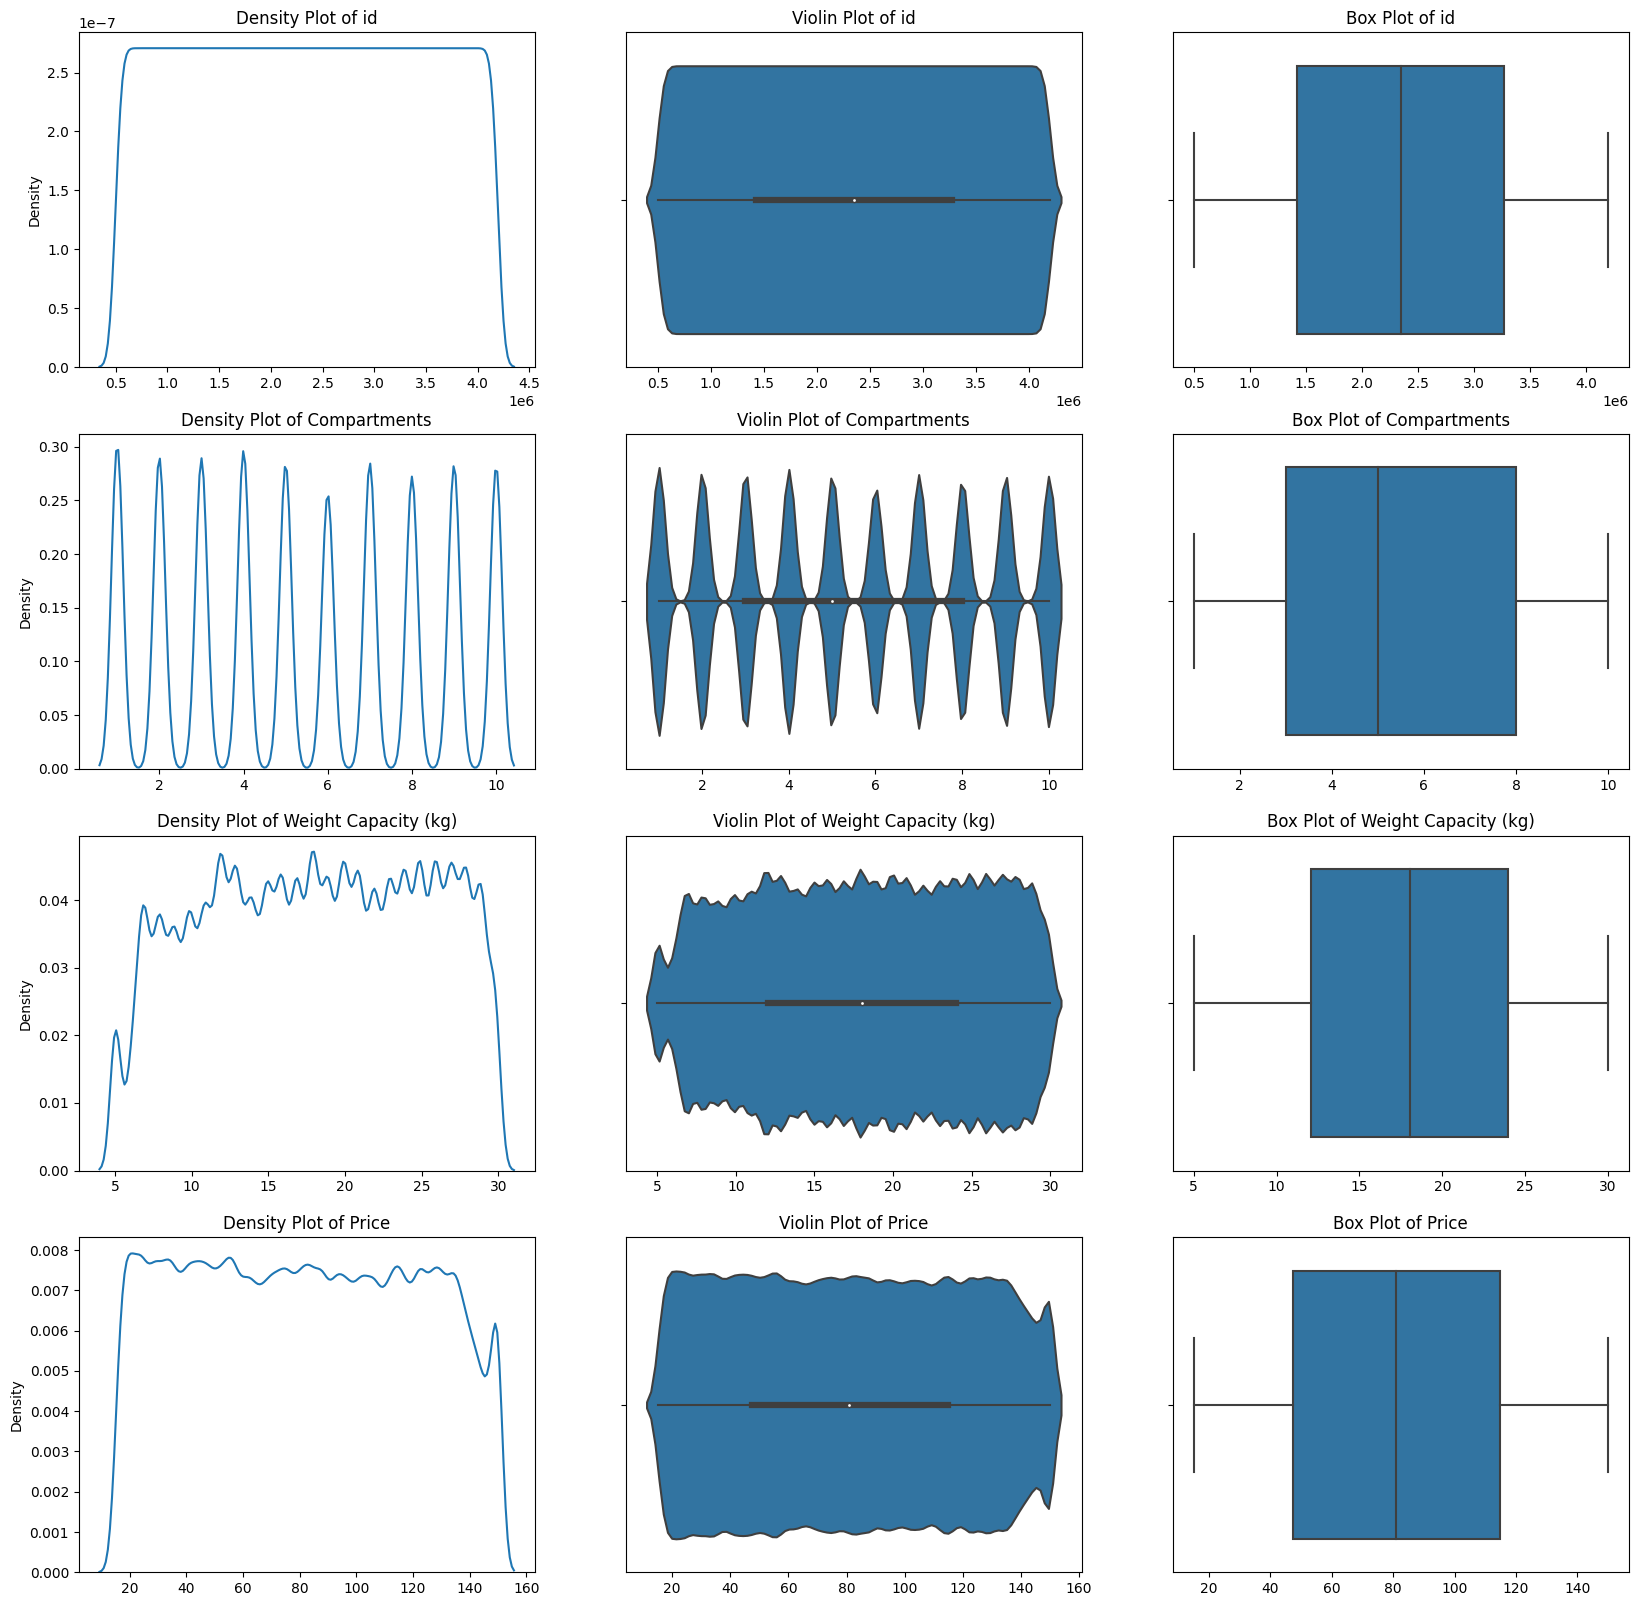

In [8]:
fig, axs = plt.subplots(4,3, figsize=(20,20))
numerical_features = X_train.select_dtypes(exclude='object').columns
r = 0
for feat in numerical_features:
    c = 0
    while c<3:
        if c == 0:
            sns.kdeplot(ax=axs[r, c], data=X_train, x=feat)
            axs[r,c].set_title(f'Density Plot of {feat}')
            axs[r,c].set(xlabel=None)
        elif c == 1:
            sns.violinplot(ax=axs[r,c], data=X_train, x=feat)
            axs[r,c].set_title(f'Violin Plot of {feat}')
            axs[r,c].set(xlabel=None)
        elif c == 2:
            sns.boxplot(ax=axs[r,c], data=X_train, x=feat)
            axs[r,c].set_title(f'Box Plot of {feat}')
            axs[r,c].set(xlabel=None)
        c += 1
    r += 1

And now categorical features.

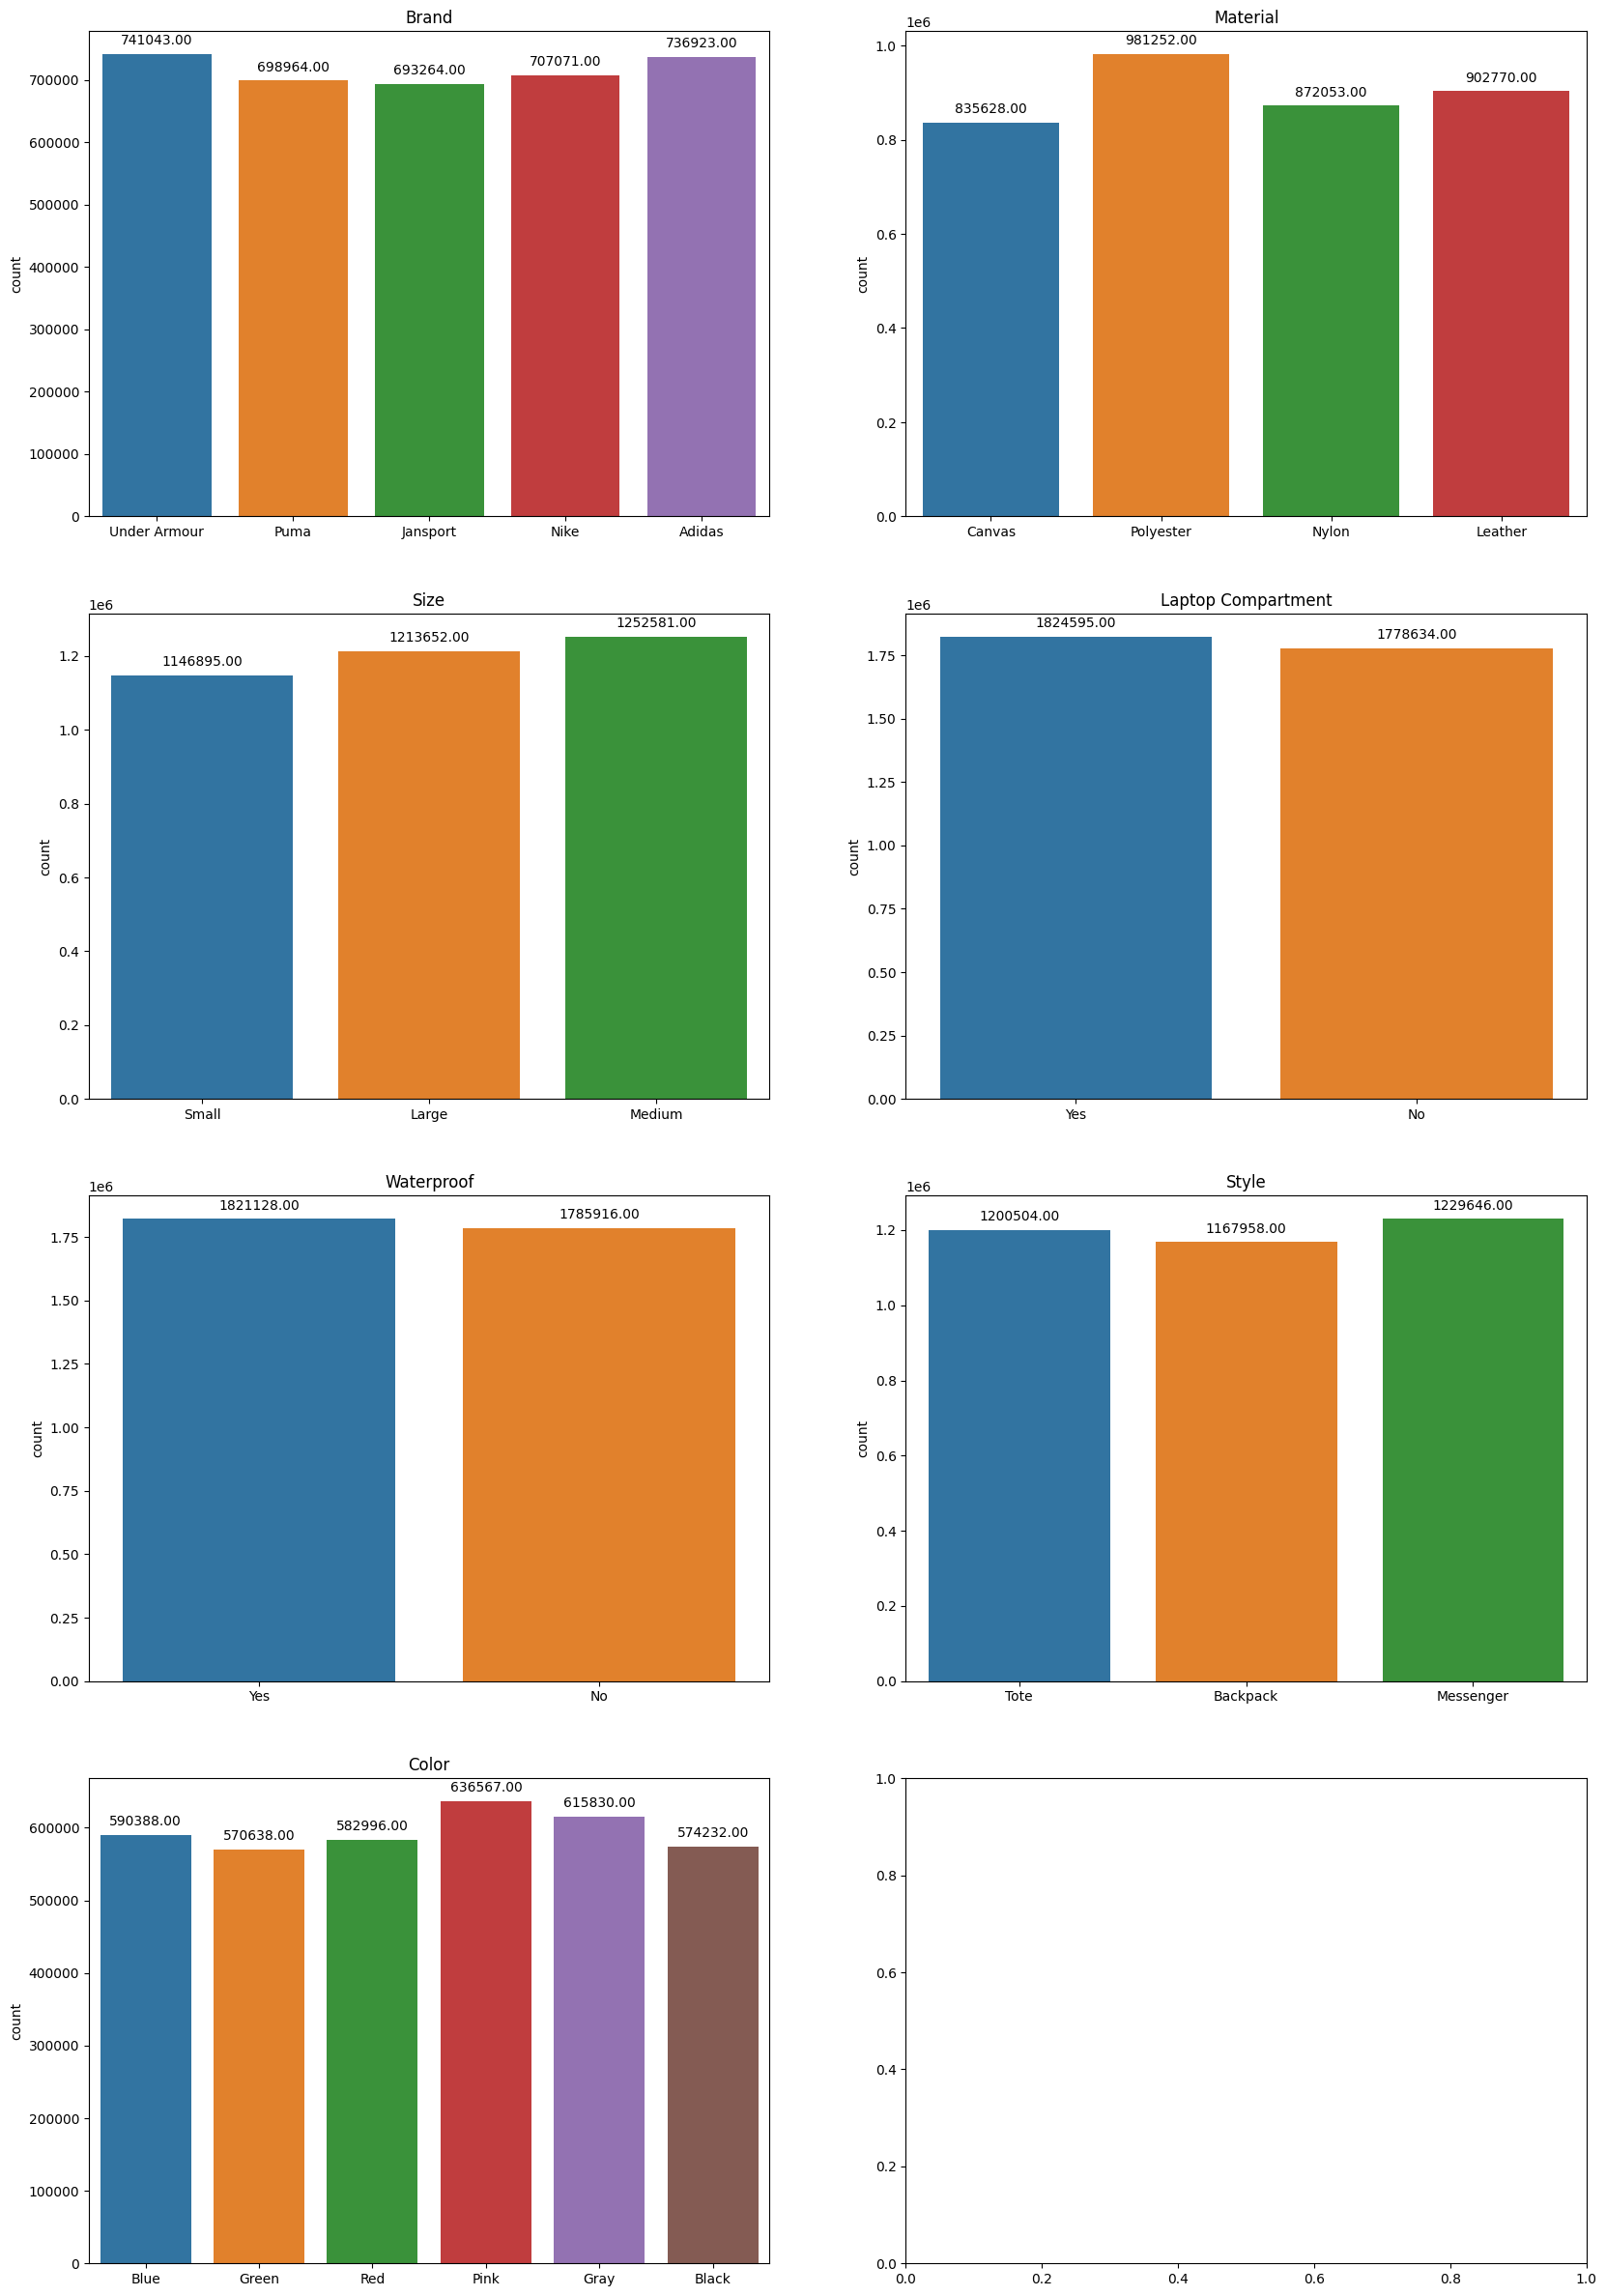

In [9]:
fig, axs = plt.subplots(4,2, figsize=(20,30))
cat_features = X_train.select_dtypes(include='object').columns
r = 0
c = 0
for feat in cat_features:
    if c == 2:
        c = 0
        r += 1
    counts = sns.countplot(ax=axs[r,c], data=X_train, x=feat)
    for p in counts.patches:
        counts.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),  ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    
    axs[r,c].set_title(f'{feat}')
    axs[r,c].set(xlabel=None)

  
    c += 1

Our features seems to be more or less equally distributed across categories.

## 🔬 Feature correlations & relationships

In this section we'll look at correlation between our features and build graphs features VS price.

<Axes: >

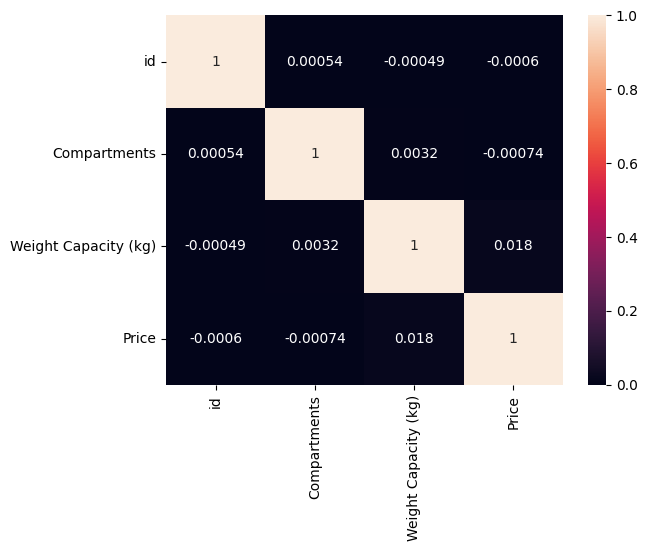

In [10]:
sns.heatmap(X_train[numerical_features].corr(), annot=True)

Our features doesn't have any correlation.

Now let's take a look on features vs target.

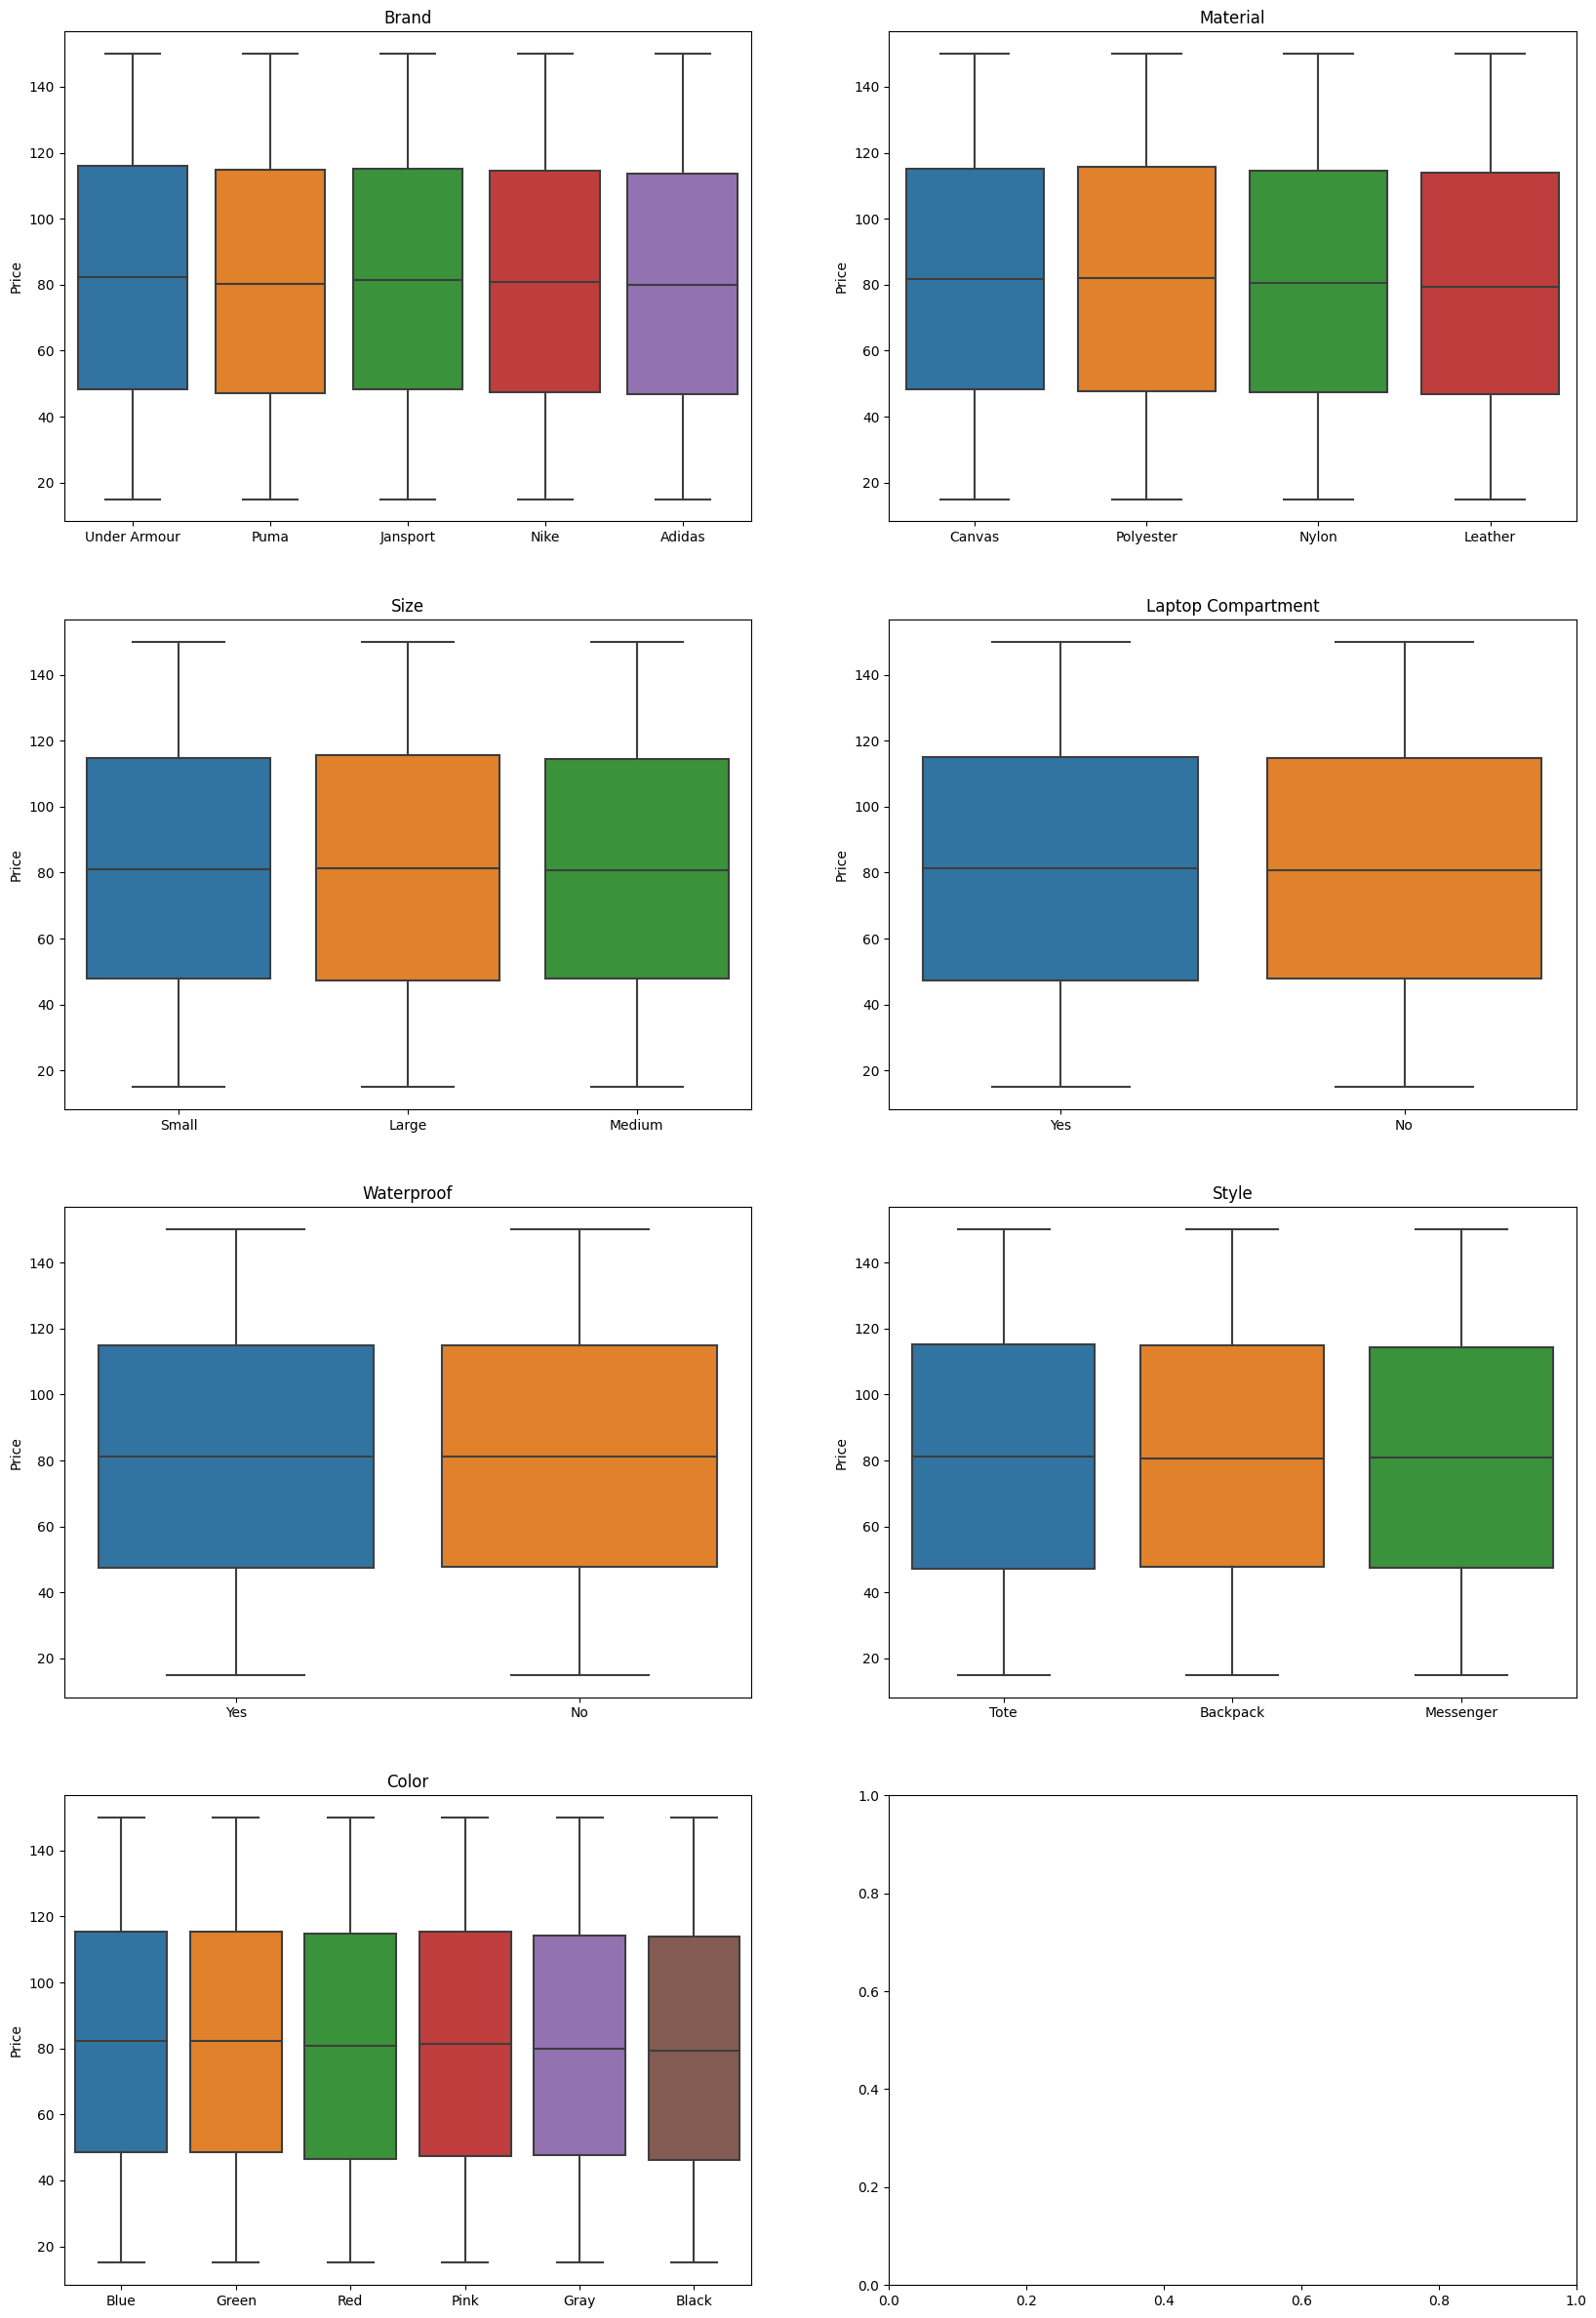

In [11]:
fig, axs = plt.subplots(4,2, figsize=(20,30))
cat_features = X_train.select_dtypes(include='object').columns
r = 0
c = 0
for feat in cat_features:
    if c == 2:
        c = 0
        r += 1
    counts = sns.boxplot(ax=axs[r,c], data=X_train, x=feat, y='Price')
    
    axs[r,c].set_title(f'{feat}')
    axs[r,c].set(xlabel=None)

  
    c += 1

## 💼 Group data by columns and get mean price

**Version 3**

After exploring the discussions it seems the target variable it just a random noise. Let's check it by grouping categorical columns and calculating average price.

**Version 14**

Extra training data was added, so data less looking like a noise

In [12]:
grouped_df = pd.read_csv('/kaggle/input/playground-series-s5e2/train.csv')

In [13]:
for c in grouped_df.select_dtypes(include='object').columns:
    print(grouped_df.groupby(c)['Price'].mean())
    print()

Brand
Adidas          80.631060
Jansport        81.791276
Nike            81.319209
Puma            81.448607
Under Armour    81.976311
Name: Price, dtype: float64

Material
Canvas       82.106511
Leather      80.437883
Nylon        81.024760
Polyester    82.033315
Name: Price, dtype: float64

Size
Large     81.651446
Medium    81.343418
Small     81.424674
Name: Price, dtype: float64

Laptop Compartment
No     81.464702
Yes    81.463842
Name: Price, dtype: float64

Waterproof
No     81.572050
Yes    81.403489
Name: Price, dtype: float64

Style
Backpack     81.402513
Messenger    81.410925
Tote         81.374865
Name: Price, dtype: float64

Color
Black    80.513439
Blue     82.006994
Gray     80.851971
Green    82.381308
Pink     81.630864
Red      81.011644
Name: Price, dtype: float64



In [14]:
for c in grouped_df.select_dtypes(exclude='object').columns:
    print(grouped_df.groupby(c)['Price'].mean())
    print()

id
0         112.15875
1          68.88056
2          39.17320
3          80.60793
4          86.02312
            ...    
299995    129.99749
299996     19.85819
299997    111.41364
299998    115.89080
299999     26.72762
Name: Price, Length: 300000, dtype: float64

Compartments
1.0     81.263845
2.0     81.171776
3.0     81.332909
4.0     81.969078
5.0     81.477310
6.0     81.452368
7.0     81.440569
8.0     81.906747
9.0     80.418818
10.0    81.685283
Name: Price, dtype: float64

Weight Capacity (kg)
5.000000      78.304714
5.004444     132.156440
5.008382     143.890560
5.009731     144.075910
5.010086     104.852040
                ...    
29.996888    117.151670
29.997986     68.255628
29.998925    104.765930
29.999796     35.365320
30.000000     73.791875
Name: Price, Length: 181596, dtype: float64

Price
15.00000      15.00000
15.00634      15.00634
15.01818      15.01818
15.01980      15.01980
15.02274      15.02274
               ...    
149.97224    149.97224
149.98784    

Interesting! So average price in all groups somehow is close to average. Remind me regression towards the mean at insurance competition.

## 💻 Conclusions

From our EDA we can draw the next conclusions:
* The most popular brand is **Adidas**👟;
* The most popular material is **Polyester** 🧵;
* The most popular size is **Medium** 📏;
* On average, backpacks have **5** compartments 🎒;
* **Laptop Compartment** is the most crucial thing in a backpack 💻;
* **Waterproof** is also crucial 🌧️, which is logical for keeping laptops and other important things safe (like money 💸);
* **Messenger** backpacks are the most popular option for style 💼;
* Preferred color is **Pink** 🌸;
* Average weight capacity is **18 kg** ⚖️;
* Average price is **81$** 💵.

After exploring distributions and relationships between our features, we can conclude the following:

* Features **don't have** any correlation 📉🤷‍♀️
* Categorical features are **equally distributed** among categories 🔄📊
* Price is also **equally distributed** among different categories 💸📈

These insights suggest that our dataset maintains a balanced spread, which is promising for further modeling and analysis.

# 3️⃣ Data Preprocessing & Feature Engineering 🏗️

## 💉 Imputation of missing data
Because our dataset contains missing values, we need to fill them in so that our models can work with clear, complete data! 🚀✨ While some models can handle missing data, most of our machine learning algorithms require a dataset without any NaN's for accurate predictions.

Here's our plan for imputation:

* **Numerical Features:**
We can impute missing values with the median of the column. This approach helps maintain the overall distribution of the data 📊🔢.

* **Categorical Features:**
For categorical features, we can impute missing values using the mode (i.e., the most frequent value). This ensures that we preserve the most common category in our dataset 🏷️🔄.

By handling missing data this way, we ensure that our machine learning models receive clean and consistent data, which is crucial for robust performance and reliable predictions. 

In [15]:
# Define imputation strategies
categorical_features = ["Brand", "Material", "Size", "Laptop Compartment", "Waterproof", "Style", "Color"]
numerical_features = ["Weight Capacity (kg)"]

# Fill categorical missing values with mode (most frequent value)
for col in categorical_features:
    X_train[col].fillna(X_train[col].mode()[0], inplace=True)
    X_test[col].fillna(X_test[col].mode()[0], inplace=True)

# Fill numerical missing values with median
for col in numerical_features:
    X_train[col].fillna(X_train[col].median(), inplace=True)
    X_test[col].fillna(X_test[col].median(), inplace=True)

## 🛠️ Creating new features

Mostly with our raw features, our model can't unleash its full potential 🚫🚀. However, when we dive into feature engineering, we're essentially explaining the world to our model by revealing hidden relationships and intricate patterns in the data 🌍🔍.

By creating new features, we provide additional context and insights that raw data alone may not capture. This process allows the model to understand the nuances of the problem space, unlocking hidden potential and significantly boosting performance 📈🤖.

In other words, transforming and combining raw features is like giving the model a richer vocabulary to describe the underlying phenomena—leading to smarter predictions and improved outcomes 🎯💡✨.

In [16]:
def perform_feature_engineering(df):
    # Brand Material Interaction - Certain materials may be common for specific brands
    df['Brand_Material'] = df['Brand'] + '_' + df['Material']

    # Brand & Size Interaction - Some brands may produce only specific sizes
    df['Brand_Size'] = df['Brand'] + '_' + df['Size']

    # Has Laptop Compartment - Convert Yes/No to 1/0 for easier analysis
    df['Has_Laptop_Compartment'] = df['Laptop Compartment'].map({'Yes': 1, 'No': 0})

    # Is Waterproof - Convert Yes/No to 1/0 for easier analysis
    df['Is_Waterproof'] = df['Waterproof'].map({'Yes': 1, 'No': 0})

    # Compartments Binning - Group compartments into categories
    df['Compartments_Category'] = pd.cut(df['Compartments'], bins=[0, 2, 5, 10, np.inf], labels=['Few', 'Moderate', 'Many', 'Very Many'])

    # Weight Capacity Ratio - Normalize weight capacity using the max value
    df['Weight_Capacity_Ratio'] = df['Weight Capacity (kg)'] / df['Weight Capacity (kg)'].max()

    # Interaction Feature: Weight vs. Compartments - Some bags may hold more with less compartments
    df['Weight_to_Compartments'] = df['Weight Capacity (kg)'] / (df['Compartments'] + 1)  # Avoid division by zero

    # Style and Size Interaction - Certain styles may correlate with sizes
    df['Style_Size'] = df['Style'] + '_' + df['Size']

    return df


In [17]:
X_train_fe = perform_feature_engineering(X_train.copy())
X_test_fe = perform_feature_engineering(X_test.copy())

## ✂️ Split features and target

In [18]:
y_train = X_train_fe.Price
X_train_fe.drop('Price', axis=1, inplace=True)

## 🏷️ Encoding categorical variables

Our models only works well with number, so we need to encode our categorical features. The most common way it's ohe-hot-encoding.

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [20]:
def encode_features(X_train, X_test):
    combined_df = pd.concat([X_train, X_test], axis=0)
    categorical_columns = combined_df.select_dtypes(include=['object', 'category']).columns
    numerical_columns = combined_df.select_dtypes(exclude=['object', 'category']).columns.tolist()
    print(numerical_columns)


    preprocessor = ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_columns)
        ],
        remainder='passthrough' 
    )
    
    preprocessor.fit(combined_df)
    
    X_train_nan_encoded = preprocessor.transform(X_train)
    X_test_nan_encoded = preprocessor.transform(X_test)
    
    encoded_feature_names = preprocessor.get_feature_names_out()
    X_train_encoded_df = pd.DataFrame(X_train_nan_encoded, columns=encoded_feature_names)
    X_test_encoded_df = pd.DataFrame(X_test_nan_encoded, columns=encoded_feature_names)

    return X_train_encoded_df, X_test_encoded_df

In [21]:
X_train_encoded_df, X_test_encoded_df = encode_features(X_train_fe, X_test_fe)

['id', 'Compartments', 'Weight Capacity (kg)', 'Has_Laptop_Compartment', 'Is_Waterproof', 'Weight_Capacity_Ratio', 'Weight_to_Compartments']


## ✂️ Split features into train and validation set

It's a crucial step in accessing the model's perfomance. This approach assures us that we're having two separate sets: one for training and other for validation to see did our model perform well on unseen data.

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
x_train, x_val, y_train, y_val = train_test_split(X_train_encoded_df, y_train, test_size=0.15, random_state=42)

# 4️⃣ Training & Model Evaluation🤖

* **Version 3**: Simple models without tuning hyperparameters.

In this section, we'll train our machine learning model to predict the price of our backpacks! 🚀💰 Our approach will be experimental and comprehensive, as we plan to try a variety of machine learning methods to see which one works best for our data.

Here's how we'll structure this section:

**Multiple Subsections:**
Each subsection will focus on a different machine learning method. We'll experiment with various algorithms to uncover the strengths and weaknesses of each approach. For example, we might try:

* Linear Regression 📉
* Decision Trees 🌳
* Random Forests 🌲
* Gradient Boosting Machines ⚡
* Support Vector Machines 🤖
* Neural Networks 🧠

**Experimentation and Comparison:**
The goal is to try as many methods as possible, tuning them to get the best out of each. We'll keep track of:

* Hyperparameter tuning 🔧
* Training and validation performance 📊
* Potential overfitting/underfitting issues 🤔

**Evaluation Section:**
After training, we'll move on to an evaluation section where we:

* Compare the performance of each model using relevant metrics (e.g., MAE, RMSE, R²) 📈
* Analyze which model has the best performance for predicting the backpack prices 🎯
* Discuss insights and potential next steps for further improvement 🔍

By breaking down our approach into these subsections, we can clearly see how each machine learning method contributes to our overall goal. This modular strategy not only makes the notebook easier to follow but also allows us to experiment widely and pinpoint the most effective model for our problem. Let's get started and see which method will unlock the highest predictive power! 💡🔥

In [24]:
def rmse(y_true, y_pred):
    return np.sqrt(np.sum(((y_true-y_pred)**2)/len(y_true)))



scores = {'model': [],
          'model_name':[], 
         'rmse': []
         }

def add_scores_rmse(model, model_name, y_true, y_pred):
    error = rmse(y_true, y_pred)
    scores['model'].append(model)
    scores['model_name'].append(model_name)
    scores['rmse'].append(error)
    print(f'RMSE for {model_name}: {error}')
    

## 🏠 Baseline model 🏠

For baseline model we might use a DummyRegressor from scikit-learn.

A **dummy regressor** is a simple machine learning model that predicts numerical values using basic rules, without actually learning from the input data. Often it's using as a baseline, because is useful as a simple baseline to compare with other (real) regressors. It shouldn't be used it for real problems.

In [25]:
from sklearn.dummy import DummyRegressor

In [26]:
dummy = DummyRegressor()
dummy.fit(x_train, y_train)

DummyRegressor()

In [27]:
scores

{'model': [], 'model_name': [], 'rmse': []}

In [28]:
add_scores_rmse(dummy, 'DummyRegressor', y_val, dummy.predict(x_val))

RMSE for DummyRegressor: 38.91494384917242


Good, so we're having a baseline in 38.9484. Let's see if we can beat it!

## 🌲Random Forest🌲

In [29]:
from sklearn.model_selection import cross_val_score

In [30]:
from sklearn.ensemble import RandomForestRegressor

In [31]:
def rf_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'warm_start': trial.suggest_int('warm_start', 0, 1),
        'max_features':trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    }

    rf_model = RandomForestRegressor(**params)
    
    return -1*cross_val_score(rf_model, x_train, y_train, n_jobs=-1, cv=3, scoring='neg_root_mean_squared_error').mean()

In [32]:
# study = optuna.create_study(direction='minimize')
# study.optimize(rf_objective, n_trials=100)
# trial = study.best_trial

In [33]:
param = {'n_estimators': 259, 'max_depth': 7, 'warm_start': 1, 'max_features': 'sqrt'}

In [34]:
# rf = RandomForestRegressor(**param)
# rf.fit(x_train, y_train)

In [35]:
# add_scores_rmse(rf, 'RandomForestRegressor', y_val, rf.predict(x_val))

## ❎ XGBoost ❎

In [36]:
from xgboost import XGBRegressor

In [37]:
def objective_xgb(trial):
    # params = {
    #     'n_estimators': trial.suggest_int('n_estimators', 20, 500),
    #     'max_depth': int(trial.suggest_float('max_depth', 1, 100, log=True)),
    #     'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
    #     'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
    #     'gamma': trial.suggest_float('gamma', 0, 2),
    #     'max_delta_step': trial.suggest_float('max_delta_step', 0, 10),
    #     'subsample': trial.suggest_float('subsample', 0, 1)
    # }

    params = {        
            "n_estimators": trial.suggest_int("n_estimators", 50, 1000, step=100),
            "max_depth":trial.suggest_int("max_depth", 1, 10),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 8),
            "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True), 
            "subsample": trial.suggest_float("subsample", 0.7, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-2, 10.),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 10.),
            "gamma": trial.suggest_float("gamma", 0.01, 1.0),
            "verbosity": 0, 
            "device": 'gpu', 
            "objective": 'reg:squarederror', 
            "tree_method": 'gpu_hist'
    }    
    
    xgb_model = XGBRegressor(**params)

    return -1*cross_val_score(xgb_model, x_train, y_train, n_jobs=-1, cv=3, scoring='neg_root_mean_squared_error').mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective_xgb, n_trials=100)
trial = study.best_trial

[I 2025-02-03 21:19:48,823] A new study created in memory with name: no-name-a93e4156-db16-4e1a-b3aa-e58d95480038
[I 2025-02-03 21:21:07,388] Trial 0 finished with value: 38.92285120950364 and parameters: {'n_estimators': 850, 'max_depth': 3, 'min_child_weight': 7, 'learning_rate': 0.000495882231086052, 'subsample': 0.9396886094064406, 'colsample_bytree': 0.762220348495141, 'reg_alpha': 3.7797350550818525, 'reg_lambda': 1.8977185670916301, 'gamma': 0.8658958217744127}. Best is trial 0 with value: 38.92285120950364.
[I 2025-02-03 21:22:58,126] Trial 1 finished with value: 38.92024586214679 and parameters: {'n_estimators': 550, 'max_depth': 9, 'min_child_weight': 7, 'learning_rate': 0.0008116864997256449, 'subsample': 0.7018894813497684, 'colsample_bytree': 0.33876230659017736, 'reg_alpha': 1.6316422203194123, 'reg_lambda': 0.9079937076018083, 'gamma': 0.16181714706193323}. Best is trial 1 with value: 38.92024586214679.
[I 2025-02-03 21:23:57,449] Trial 2 finished with value: 38.92555545

In [38]:
param = trial.params
#param = {'n_estimators': 450, 'max_depth': 4, 'min_child_weight': 7, 'learning_rate': 0.010230533167302816, 'subsample': 0.7977355633601261, 'colsample_bytree': 0.1526355211804084, 'reg_alpha': 3.016256372030049, 'reg_lambda': 9.491053950347876, 'gamma': 0.7}
#param = {'n_estimators': 450, 'max_depth': 1, 'min_child_weight': 2, 'learning_rate': 0.05106717951268276, 'subsample': 0.8179078683056303, 'colsample_bytree': 0.5995719977594407, 'reg_alpha': 3.4566350070836216, 'reg_lambda': 7.86626093277777, 'gamma': 0.4063751228507485}

In [39]:
xgb = XGBRegressor(**param)
xgb.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.36719528828306813, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.44748881496157156,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.08264629037419823,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=650, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [40]:
add_scores_rmse(xgb, 'XGBRegressor', y_val, xgb.predict(x_val))

RMSE for XGBRegressor: 38.87541152189964


## 🐱 CatBoost 🐱

In [41]:
from catboost import CatBoostRegressor

In [42]:
def objective_cat(trial):
    # params = {
    #     'n_estimators': trial.suggest_int('n_estimators', 20, 500),
    #     'max_depth': int(trial.suggest_float('max_depth', 1, 100, log=True)),
    #     'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
    #     'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
    #     'gamma': trial.suggest_float('gamma', 0, 2),
    #     'max_delta_step': trial.suggest_float('max_delta_step', 0, 10),
    #     'subsample': trial.suggest_float('subsample', 0, 1)
    # }

    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000), 
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 200),  
        'depth': trial.suggest_int('depth', 1, 16),  
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10),  
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'task_type': 'GPU',
        'verbose': 0
    }

    
    cat_model = CatBoostRegressor(**params)

    return -1*cross_val_score(cat_model, x_train, y_train, n_jobs=1, cv=3, scoring='neg_root_mean_squared_error').mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective_cat, n_trials=100)
trial = study.best_trial

[I 2025-02-03 23:13:27,808] A new study created in memory with name: no-name-dd429cc8-afa3-4a18-91e9-000e351e2279
[I 2025-02-03 23:14:16,590] Trial 0 finished with value: 38.90061681742487 and parameters: {'iterations': 703, 'early_stopping_rounds': 46, 'depth': 7, 'l2_leaf_reg': 8.337768436852654, 'learning_rate': 0.00901442160261773}. Best is trial 0 with value: 38.90061681742487.
[I 2025-02-03 23:16:29,459] Trial 1 finished with value: 38.92506647628888 and parameters: {'iterations': 834, 'early_stopping_rounds': 193, 'depth': 12, 'l2_leaf_reg': 7.267037690560636, 'learning_rate': 0.026390091893693325}. Best is trial 0 with value: 38.90061681742487.
[I 2025-02-03 23:20:05,148] Trial 2 finished with value: 39.07483663363292 and parameters: {'iterations': 606, 'early_stopping_rounds': 94, 'depth': 14, 'l2_leaf_reg': 5.694668932861263, 'learning_rate': 0.09086342974844382}. Best is trial 0 with value: 38.90061681742487.
[I 2025-02-03 23:22:16,818] Trial 3 finished with value: 38.903676

In [43]:
param = trial.params
#param = {'iterations': 757, 'early_stopping_rounds': 111, 'depth': 1, 'l2_leaf_reg': 2.51131199440927, 'learning_rate': 0.060630663020744394}

In [44]:
cat_model = CatBoostRegressor(**param)
cat_model.fit(x_train, y_train)

0:	learn: 38.9305822	total: 148ms	remaining: 2m 5s
1:	learn: 38.9281306	total: 287ms	remaining: 2m 1s
2:	learn: 38.9260845	total: 426ms	remaining: 1m 59s
3:	learn: 38.9243920	total: 572ms	remaining: 2m
4:	learn: 38.9229429	total: 706ms	remaining: 1m 58s
5:	learn: 38.9216772	total: 840ms	remaining: 1m 57s
6:	learn: 38.9205030	total: 976ms	remaining: 1m 56s
7:	learn: 38.9195470	total: 1.11s	remaining: 1m 56s
8:	learn: 38.9185983	total: 1.25s	remaining: 1m 56s
9:	learn: 38.9178218	total: 1.38s	remaining: 1m 55s
10:	learn: 38.9170779	total: 1.52s	remaining: 1m 55s
11:	learn: 38.9164008	total: 1.66s	remaining: 1m 55s
12:	learn: 38.9158381	total: 1.79s	remaining: 1m 54s
13:	learn: 38.9153142	total: 1.93s	remaining: 1m 54s
14:	learn: 38.9148837	total: 2.06s	remaining: 1m 54s
15:	learn: 38.9144543	total: 2.19s	remaining: 1m 53s
16:	learn: 38.9139430	total: 2.33s	remaining: 1m 53s
17:	learn: 38.9135771	total: 2.47s	remaining: 1m 53s
18:	learn: 38.9131527	total: 2.61s	remaining: 1m 53s
19:	learn

In [45]:
add_scores_rmse(cat_model, 'CatRegressor', y_val, cat_model.predict(x_val))

RMSE for CatRegressor: 38.87529466330781


## 💡 LightGBM 💡

In [46]:
from lightgbm import LGBMRegressor

In [47]:
def objective_light(trial):
    # params = {
    #     'n_estimators': trial.suggest_int('n_estimators', 20, 500),
    #     'max_depth': int(trial.suggest_float('max_depth', 1, 100, log=True)),
    #     'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
    #     'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
    #     'gamma': trial.suggest_float('gamma', 0, 2),
    #     'max_delta_step': trial.suggest_float('max_delta_step', 0, 10),
    #     'subsample': trial.suggest_float('subsample', 0, 1)
    # }

    params = {        
            "n_estimators": trial.suggest_int("n_estimators", 50, 1000, step=100),
            "max_depth":trial.suggest_int("max_depth", 4, 10),
            "min_child_weight": trial.suggest_int("min_child_weight", 7, 15),
            "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True), 
            "subsample": trial.suggest_float("subsample", 0.7, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-2, 10.),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 10.),
            "num_leaves": trial.suggest_int("num_leaves", 2^4+1, 2^10+1),
            'verbosity':0,
            'device': 'gpu'
    }    
    
    light_model = LGBMRegressor(**params)

    return -1*cross_val_score(light_model, x_train, y_train, n_jobs=-1, cv=3, scoring='neg_root_mean_squared_error').mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective_light, n_trials=100)
trial = study.best_trial

[I 2025-02-04 00:33:51,420] A new study created in memory with name: no-name-a194b098-0cdd-428e-b380-357f8287d755
[I 2025-02-04 00:35:04,054] Trial 0 finished with value: 38.894949993659175 and parameters: {'n_estimators': 450, 'max_depth': 9, 'min_child_weight': 7, 'learning_rate': 0.07753182729914986, 'subsample': 0.9659497780691627, 'colsample_bytree': 0.10467359526785465, 'reg_alpha': 2.2527568160342324, 'reg_lambda': 7.121534980325027, 'num_leaves': 8}. Best is trial 0 with value: 38.894949993659175.
[I 2025-02-04 00:37:24,038] Trial 1 finished with value: 38.91247410315425 and parameters: {'n_estimators': 850, 'max_depth': 4, 'min_child_weight': 7, 'learning_rate': 0.0017383747338366414, 'subsample': 0.8539063340557331, 'colsample_bytree': 0.4979089474205616, 'reg_alpha': 3.3941278632925838, 'reg_lambda': 6.34123456680776, 'num_leaves': 7}. Best is trial 0 with value: 38.894949993659175.
[I 2025-02-04 00:37:39,417] Trial 2 finished with value: 38.90482977120835 and parameters: {'

In [48]:
param = trial.params
#param = {'n_estimators': 950, 'max_depth': 6, 'min_child_weight': 8, 'learning_rate': 0.010420837349282069, 'subsample': 0.7668565054850575, 'colsample_bytree': 0.10035808296187733, 'reg_alpha': 9.064791632557105, 'reg_lambda': 4.768416974088945, 'num_leaves': 9}

In [49]:
light_model = LGBMRegressor(**param)
light_model.fit(x_train, y_train)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1179
[LightGBM] [Info] Number of data points in the train set: 3140170, number of used features: 79
[LightGBM] [Info] Start training from score 81.351593


LGBMRegressor(colsample_bytree=0.13138520881272656,
              learning_rate=0.09919135392165795, max_depth=7,
              min_child_weight=14, n_estimators=550, num_leaves=8,
              reg_alpha=0.5208941568169729, reg_lambda=1.22117449823864,
              subsample=0.9787568177167378)

In [50]:
add_scores_rmse(light_model, 'LightGBMRegressor', y_val, light_model.predict(x_val))

RMSE for LightGBMRegressor: 38.875204555638305


## 🧱 Stacking 🧱

In [51]:
from sklearn.ensemble import StackingRegressor

In [52]:
estimators = [
    ('lgb', light_model),
    ('xgb', xgb),
     ('cat', cat_model)
]
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=10,
                                          random_state=42)
)
reg.fit(x_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1179
[LightGBM] [Info] Number of data points in the train set: 3140170, number of used features: 79
[LightGBM] [Info] Start training from score 81.351593
0:	learn: 38.9305822	total: 237ms	remaining: 3m 20s
1:	learn: 38.9281306	total: 432ms	remaining: 3m 2s
2:	learn: 38.9260845	total: 647ms	remaining: 3m 1s
3:	learn: 38.9243920	total: 807ms	remaining: 2m 49s
4:	learn: 38.9229429	total: 940ms	remaining: 2m 38s
5:	learn: 38.9216772	total: 1.07s	remaining: 2m 30s
6:	learn: 38.9205030	total: 1.21s	remaining: 2m 24s
7:	learn: 38.9195470	total: 1.34s	remaining: 2m 20s
8:	learn: 38.9185983	total: 1.48s	remaining: 2m 17s
9:	learn: 38.9178218	total: 1.61s	remaining: 

StackingRegressor(estimators=[('lgb',
                               LGBMRegressor(colsample_bytree=0.13138520881272656,
                                             learning_rate=0.09919135392165795,
                                             max_depth=7, min_child_weight=14,
                                             n_estimators=550, num_leaves=8,
                                             reg_alpha=0.5208941568169729,
                                             reg_lambda=1.22117449823864,
                                             subsample=0.9787568177167378)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_byle...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None, min_child_weight=2,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=650, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                              ('cat',
                               <catboost.core.CatBoostRegressor object at 0x7b413bf307c0>)],
                  final_estimator=RandomForestRegressor(n_estimators=10,
                                                        random_state=42))

In [53]:
add_scores_rmse(reg, 'Stacking', y_val, reg.predict(x_val))

RMSE for Stacking: 41.78527561360927


## 🗳️ Voting 🗳️

In [54]:
from sklearn.ensemble import VotingRegressor


In [55]:
softvoting = VotingRegressor(estimators=[('xgb', xgb),('lgb', light_model),('cat', cat_model)])

In [56]:
softvoting.fit(x_train, y_train)
add_scores_rmse(reg, 'Voting', y_val, softvoting.predict(x_val))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1179
[LightGBM] [Info] Number of data points in the train set: 3140170, number of used features: 79
[LightGBM] [Info] Start training from score 81.351593
0:	learn: 38.9305822	total: 146ms	remaining: 2m 3s
1:	learn: 38.9281306	total: 286ms	remaining: 2m
2:	learn: 38.9260845	total: 449ms	remaining: 2m 6s
3:	learn: 38.9243920	total: 627ms	remaining: 2m 12s
4:	learn: 38.9229429	total: 776ms	remaining: 2m 10s
5:	learn: 38.9216772	total: 909ms	remaining: 2m 7s
6:	learn: 38.9205030	total: 1.04s	remaining: 2m 5s
7:	learn: 38.9195470	total: 1.18s	remaining: 2m 3s
8:	learn: 38.9185983	total: 1.31s	remaining: 2m 2s
9:	learn: 38.9178218	total: 1.45s	remaining: 2m
10:	l

# 5️⃣ Predictions & Submission 📝

In [57]:
for i in range(len(scores['model'])):
    model = scores['model'][i]
    pred = model.predict(X_test_encoded_df)
    print(f'RMSE for {scores["model_name"][i]}: {scores["rmse"][i]}')
    submission = pd.DataFrame({
        "id": X_test['id'],
        'Price': pred
    })
    submission.to_csv(f'submission_{scores["model_name"][i]}.csv', index=False)


RMSE for DummyRegressor: 38.91494384917242
RMSE for XGBRegressor: 38.87541152189964
RMSE for CatRegressor: 38.87529466330781
RMSE for LightGBMRegressor: 38.875204555638305
RMSE for Stacking: 41.78527561360927
RMSE for Voting: 38.874179895660305
